## PRACTICAL 5: CLASSIFICATION MINING ##

* Using supervised machine learning algorithms 

In [1]:
# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the dataset
import pandas as pd
import numpy as np
bikes=pd.read_excel("Bike_Sales.xlsx")
bikes2=bikes.drop_duplicates()
print('Shape before deleting duplicate values:', bikes.shape)
print('Shape before deleting duplicate values:', bikes2.shape)

Shape before deleting duplicate values: (113036, 18)
Shape before deleting duplicate values: (112029, 18)


**A. DEFINE THE PROBLEM**
* Create a classifier model or Predictive model for the Age_Group in the Bike_Sales dataset
* Target Variable: Age_Group
* Potential Predictors: Date to Revenue.
* Create a supervised ML classification model, as the target variable is categorical.

## 1. DECISION TREE CLASSIFIER ##
* Splits data in to training and testing data
* Train the model on 70-80 of the data
* Test the model on 20-30% of the data
* Model generates accuracy scores (it's preferable to have scores above 75%)
* Decision tree generates gini index which is a measure used to evaluate the quality of a split at a node
* The split with the lowest Gini index is typically chosen as the best option

predictors
target

**A. Clean the data**

**i. Removing unneccessary variables**

In [3]:
# Deleting those columns which are not useful in predictive analysis because these variables are qualitative
UselessColumns = ['Date', 'Day', 'Month', 'Year']
bikes3 = bikes2.drop(UselessColumns,axis=1)
bikes3.head()

,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,17,Youth (<25),M,Canada,British Columbia,Bikes,Road Bikes,"Road-250 Red, 44",2,1519,2443,1848,3038,4886
1,23,Youth (<25),M,Australia,Victoria,Bikes,Mountain Bikes,"Mountain-200 Black, 46",2,1252,2295,2086,2504,4590
2,33,Young Adults (25-34),F,France,Yveline,Bikes,Road Bikes,"Road-150 Red, 48",2,2171,3578,2814,4342,7156
3,39,Adults (35-64),M,United States,Washington,Bikes,Road Bikes,"Road-550-W Yellow, 38",2,713,1120,814,1426,2240
4,42,Adults (35-64),M,United States,California,Bikes,Road Bikes,"Road-750 Black, 44",2,344,540,392,688,1080


**ii. Check for missing data**

In [4]:
bikes3.columns

Index(['Customer_Age', 'Age_Group', 'Customer_Gender', 'Country', 'State',
       'Product_Category', 'Sub_Category', 'Product', 'Order_Quantity',
       'Unit_Cost', 'Unit_Price', 'Profit', 'Cost', 'Revenue'],
      dtype='object')

In [5]:
#unique values or categories
bikes3.nunique()

Customer_Age         70
Age_Group             4
Customer_Gender       2
Country               6
State                53
Product_Category      3
Sub_Category         17
Product             130
Order_Quantity       32
Unit_Cost            34
Unit_Price           36
Profit              389
Cost                360
Revenue             436
dtype: int64

In [6]:
bikes3.isna().sum()

Customer_Age        0
Age_Group           0
Customer_Gender     0
Country             0
State               0
Product_Category    0
Sub_Category        0
Product             0
Order_Quantity      0
Unit_Cost           0
Unit_Price          0
Profit              0
Cost                0
Revenue             0
dtype: int64

**iii. Check and treat for outliers**

**B. Feature selection**
* Choose the best columns(Features/VARIABLES) which are correlated to the Target variable (Age_Group)

**i. Relationship between continuous variables and the target**

In [7]:
#Use ANOVA
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    from scipy.stats import f_oneway

    # Creating an empty list of final selected predictors
    SelectedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    
    return(SelectedPredictors)

In [8]:
#Calling the function to check which ccontinuous variables are correlated with target
ContinuousVariables=['Customer_Age', 'Order_Quantity','Unit_Cost','Unit_Price','Profit','Cost','Revenue']
FunctionAnova(inpData=bikes3, TargetVariable='Age_Group', ContinuousPredictorList=ContinuousVariables)

##### ANOVA Results ##### 

Customer_Age is correlated with Age_Group | P-Value: 0.0
Order_Quantity is correlated with Age_Group | P-Value: 3.241456319392318e-19
Unit_Cost is correlated with Age_Group | P-Value: 3.0861495825803802e-52
Unit_Price is correlated with Age_Group | P-Value: 3.186474575316427e-52
Profit is correlated with Age_Group | P-Value: 9.390477245613348e-36
Cost is correlated with Age_Group | P-Value: 5.38999273874916e-35
Revenue is correlated with Age_Group | P-Value: 1.1775681261253214e-35


['Customer_Age',
 'Order_Quantity',
 'Unit_Cost',
 'Unit_Price',
 'Profit',
 'Cost',
 'Revenue']

**ii. Relationship between categorical  variables and  the target**

In [9]:
#Using a chisquare test function
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    from scipy.stats import chi2_contingency
    
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])        
            
    return(SelectedPredictors)


In [10]:
#Call the function to run analysis
CategoricalVariables=['Customer_Gender', 'Country', 'State',
       'Product_Category', 'Sub_Category', 'Product']

# Calling the function
FunctionChisq(inpData=bikes3, 
              TargetVariable='Age_Group',
              CategoricalVariablesList= CategoricalVariables)

Customer_Gender is correlated with Age_Group | P-Value: 1.731384758502898e-14
Country is correlated with Age_Group | P-Value: 0.0
State is correlated with Age_Group | P-Value: 0.0
Product_Category is correlated with Age_Group | P-Value: 3.9758826753737856e-84
Sub_Category is correlated with Age_Group | P-Value: 2.7266141825717156e-138
Product is correlated with Age_Group | P-Value: 0.0


['Customer_Gender',
 'Country',
 'State',
 'Product_Category',
 'Sub_Category',
 'Product']

**iii. Select features for decision tree analysis**

In [11]:
SelectedColumns=['Customer_Age', 'Order_Quantity','Unit_Cost','Unit_Price','Profit','Cost','Revenue',
                'Customer_Gender', 'Country', 'State',
       'Product_Category', 'Sub_Category', 'Product']

# Selecting final columns
DataForML=bikes3[SelectedColumns]
DataForML.head()

,Customer_Age,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue,Customer_Gender,Country,State,Product_Category,Sub_Category,Product
0,17,2,1519,2443,1848,3038,4886,M,Canada,British Columbia,Bikes,Road Bikes,"Road-250 Red, 44"
1,23,2,1252,2295,2086,2504,4590,M,Australia,Victoria,Bikes,Mountain Bikes,"Mountain-200 Black, 46"
2,33,2,2171,3578,2814,4342,7156,F,France,Yveline,Bikes,Road Bikes,"Road-150 Red, 48"
3,39,2,713,1120,814,1426,2240,M,United States,Washington,Bikes,Road Bikes,"Road-550-W Yellow, 38"
4,42,2,344,540,392,688,1080,M,United States,California,Bikes,Road Bikes,"Road-750 Black, 44"


In [12]:
# Saving this final data for reference during deployment
DataForML.to_pickle('DataForML.pkl')

* Data Pre-processing for Machine Learning
1. Converting each Ordinal Categorical columns to numeric. (Categorical data that has an order to it or ranking)
2. Converting Binary nominal Categorical columns to numeric using 1/0 mapping. (Data that has two categorical labels e.g. gender)
3. Converting all other nominal categorical columns to numeric using onehot encoding (which represents categorical variables using binary vectors, i.e. 0 and 1.) or label-encoding (Represents categorical variables by assigning a unique integer to each category)

In [13]:
print(DataForML['Customer_Gender'].unique())
print(DataForML['Country'].unique())

['M' 'F']
['Canada' 'Australia' 'France' 'United States' 'United Kingdom' 'Germany']


In [14]:
#Our variables have several categories e.g. Country and State
#So we want to label-encode
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()


# Create a LabelEncoder object
le = LabelEncoder()

# Fit the object and transform the categorical variables

# Applying LabelEncoder on categorical columns
DataForML['Customer_Gender'] = le.fit_transform(DataForML['Customer_Gender'])
DataForML['Country'] = le.fit_transform(DataForML['Country'])
DataForML['State'] = le.fit_transform(DataForML['State'])
DataForML['Product_Category'] = le.fit_transform(DataForML['Product_Category'])
DataForML['Sub_Category'] = le.fit_transform(DataForML['Sub_Category'])
DataForML['Product'] = le.fit_transform(DataForML['Product'])

print(DataForML)

        Customer_Age  Order_Quantity  Unit_Cost  Unit_Price  Profit  Cost  \
0                 17               2       1519        2443    1848  3038   
1                 23               2       1252        2295    2086  2504   
2                 33               2       2171        3578    2814  4342   
3                 39               2        713        1120     814  1426   
4                 42               2        344         540     392   688   
...              ...             ...        ...         ...     ...   ...   
113031            52               2       1555        2443    1776  3110   
113032            25               1        713        1120     407   713   
113033            26               1        713        1120     407   713   
113034            33               1       1252        2295    1043  1252   
113035            44               1        713        1120     407   713   

        Revenue  Customer_Gender  Country  State  Product_Category  \
0    

In [15]:
#Or use one-hot encoding
DataForML_Numeric=pd.get_dummies(DataForML)
DataForML_Numeric

,Customer_Age,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue,Customer_Gender,Country,State,Product_Category,Sub_Category,Product
0,17,2,1519,2443,1848,3038,4886,1,1,5,1,11,66
1,23,2,1252,2295,2086,2504,4590,1,0,48,1,10,34
2,33,2,2171,3578,2814,4342,7156,0,2,52,1,11,58
3,39,2,713,1120,814,1426,2240,1,5,50,1,11,74
4,42,2,344,540,392,688,1080,1,5,6,1,11,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113031,52,2,1555,2443,1776,3110,4886,0,4,8,1,11,65
113032,25,1,713,1120,407,713,1120,0,3,15,1,11,74
113033,26,1,713,1120,407,713,1120,1,0,35,1,11,76
113034,33,1,1252,2295,1043,1252,2295,0,0,26,1,10,32


In [16]:
# Adding Target Variable to the data
DataForML_Numeric['Age_Group']=bikes3['Age_Group']

# Printing sample rows
DataForML_Numeric.head()

,Customer_Age,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Age_Group
0,17,2,1519,2443,1848,3038,4886,1,1,5,1,11,66,Youth (<25)
1,23,2,1252,2295,2086,2504,4590,1,0,48,1,10,34,Youth (<25)
2,33,2,2171,3578,2814,4342,7156,0,2,52,1,11,58,Young Adults (25-34)
3,39,2,713,1120,814,1426,2240,1,5,50,1,11,74,Adults (35-64)
4,42,2,344,540,392,688,1080,1,5,6,1,11,91,Adults (35-64)


**C. Split data for training and testing the model**

In [17]:
# Separate Target Variable and Predictor Variables
TargetVariable='Age_Group'
Predictors=['Customer_Age', 'Order_Quantity','Unit_Cost','Unit_Price','Profit','Cost','Revenue',
            'Customer_Gender', 'Country', 'State',
            'Product_Category', 'Sub_Category', 'Product']

X=DataForML_Numeric[Predictors].values
y=DataForML_Numeric[TargetVariable].values

In [18]:
# Split the data into training and testing set
#Training the model on 70% of the data and testing it on 30% of the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=428)

In [19]:
# Sanity check for the sampled data (how the split has occured)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(78420, 13)
(78420,)
(33609, 13)
(33609,)


**D. Create and test the Decision Tree Model**

DecisionTreeClassifier(criterion='entropy', max_depth=2)
                      precision    recall  f1-score   support

      Adults (35-64)       1.00      1.00      1.00     16543
       Seniors (64+)       1.00      1.00      1.00       214
Young Adults (25-34)       1.00      1.00      1.00     11493
         Youth (<25)       1.00      1.00      1.00      5359

            accuracy                           1.00     33609
           macro avg       1.00      1.00      1.00     33609
        weighted avg       1.00      1.00      1.00     33609

[[16543     0     0     0]
 [    0   214     0     0]
 [    0     0 11493     0]
 [    0     0     0  5359]]
Accuracy of the model on Testing Sample Data: 1.0

Accuracy values for 10-fold Cross Validation:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Final Average Accuracy of the model: 1.0


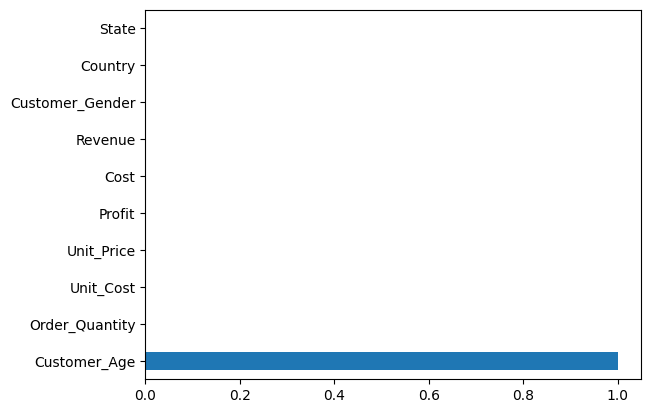

In [20]:
#Decision Trees
from sklearn import tree
#choose from different tunable hyper parameters
clf = tree.DecisionTreeClassifier(max_depth=2,criterion='entropy')

# Printing all the parameters of Decision Trees
print(clf)

# Creating the model on Training Data
DTree=clf.fit(X_train,y_train)
prediction=DTree.predict(X_test)

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

# Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(DTree.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')

# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(DTree, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


* There's a higher support for Adults(35-64) customers
* The model is 100% accurate and predicting for Age_Group
* Only the Customer_Age is important at predicting Age_Group

Precision and Accurracy Value?



**E. Create  the Decision Tree**

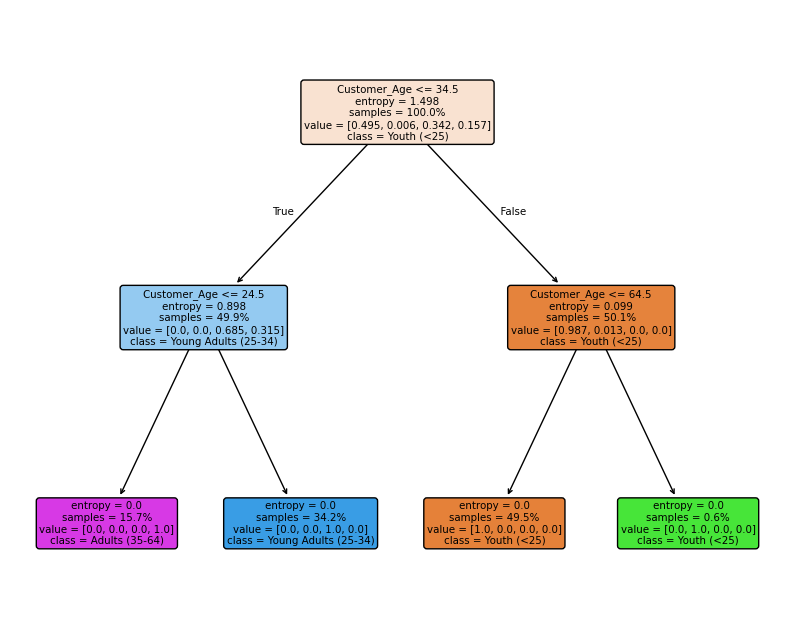

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

features = Predictors
classes = DataForML_Numeric.Age_Group

plt.figure(figsize=(10, 8))
plot_tree(clf,
          feature_names=features,
          class_names=classes,
          rounded=True, # Rounded node edges
          filled=True, # Adds color according to class
          proportion=True); # Displays the proportions of class samples instead of the whole number of samples

* Entropy is a measure of impurity or disorder in a dataset. It's used to determine the best attribute to split the data at each node.

How it works:

Calculate entropy: For a given node, the entropy is calculated based on the distribution of class labels. A perfectly pure node (all instances belong to the same class) has an entropy of 0, while a node with an equal distribution of classes has a maximum entropy.

**F. Test accuracy of model**

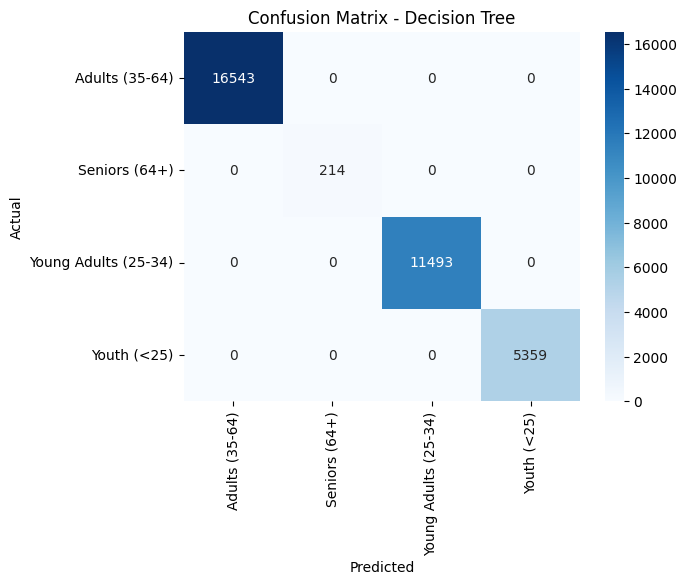

In [22]:
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 
# Plot a confusion matrix
import seaborn as sns
confusion_matrix = pd.crosstab(y_test, prediction, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

**F. Save the model**

In [23]:
## Save the model
import pickle
import os

# Saving the Python objects as serialized files can be done using pickle library
# Here let us save the Final DecisionTreeModel
with open('DecisionTreeModel.pkl', 'wb') as fileWriteStream:
    pickle.dump(clf, fileWriteStream)
    # Don't forget to close the filestream!
    fileWriteStream.close()
    
print('pickle file of Predictive Model is saved at Location:',os.getcwd())

pickle file of Predictive Model is saved at Location: c:\Users\seth\Desktop\Big Data Mining and analytics


In [24]:
#OR save the model as a joblib
import joblib
# Save the model as a joblib file
joblib.dump(clf, 'DecisionTreeModel.joblib')
print('Decision Tree Model successfully saved as joblib')

Decision Tree Model successfully saved as joblib


## 2. GAUSIAN NAïVE BAYES CLASSIFIER ##
# You'll find: 

A- <a href="#8">Using a Gaussian Naive Bayes Clustering Approach</a>

B-  <a href="#9">Splitting Data for Gaussian Naive Bayes</a>

C-  <a href="#10">Training the GNB</a>

D-  <a href="#11">Testing the GNB Model</a>


**A. Using the GNB classifier**

In [25]:
#Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

**B. Split data for training and testing**

In [26]:
# Select predictors and target variables
X = DataForML_Numeric.drop("Age_Group", axis=1)
y = DataForML_Numeric['Age_Group']

In [27]:
# Encoding the Species column to get numerical classes as GNB only take numeric data
le = LabelEncoder()
y = le.fit_transform(y)

In [28]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**C. Train the GNB model**

In [29]:
# Gaussian Naive Bayes classifier
gnb = GaussianNB()
 
# Train the classifier on 70% of the training data
gnb.fit(X_train, y_train)

GaussianNB()

**D. Test the model**

In [30]:
# Make predictions on the testing data
y_pred = gnb.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"The Accuracy of Prediction on Age_Group is: {accuracy}")

The Accuracy of Prediction on Age_Group is: 0.9790532297896397


In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     16555
           1       0.49      0.94      0.65       205
           2       0.96      1.00      0.98     11575
           3       1.00      0.95      0.97      5274

    accuracy                           0.98     33609
   macro avg       0.86      0.97      0.90     33609
weighted avg       0.98      0.98      0.98     33609

[[16169   200   186     0]
 [   12   193     0     0]
 [   38     0 11520    17]
 [    2     0   249  5023]]


## 3. SUPPORT VECTOR MACHINES (SVMs) ## 

In [32]:
#Using the Support Vector Machine classifier (SVC)
from sklearn.svm import SVC

classifier = SVC()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score
from sklearn.metrics import accuracy_score
print('accuracy is',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     16555
           1       0.00      0.00      0.00       205
           2       0.63      0.80      0.70     11575
           3       0.00      0.00      0.00      5274

    accuracy                           0.74     33609
   macro avg       0.36      0.44      0.40     33609
weighted avg       0.63      0.74      0.68     33609

[[15711     0   844     0]
 [  205     0     0     0]
 [ 2332     0  9243     0]
 [  648     0  4626     0]]
accuracy is 0.7424796929393912
